In [6]:
!pip install plotly pytransform3d

     |████████████████████████████████| 76 kB 398 kB/s eta 0:00:01
     |████████████████████████████████| 97 kB 771 kB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 11.5 MB/s eta 0:00:01
  Created wheel for pytransform3d: filename=pytransform3d-1.11.0-py3-none-any.whl size=85895 sha256=aff5ea54815d0dac0fd05265c2e3c5f5aefe5983a7415b0211510b032e3b286c
  Stored in directory: /home/docker_pntr/.cache/pip/wheels/09/0b/9b/cf11765749ef71c0af259beef1b3eb92bd4790a2877cfb878b
Successfully built pytransform3d


In [95]:
import os
from os.path import join
import pickle

from PIL import Image
import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import plotly.graph_objects as go
from pytransform3d.transformations import plot_transform
from pytransform3d.plot_utils import make_3d_axis

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [96]:
RESULTS_DIR = '../eval_results/taganrog_ride1'
IDX = 96

assert os.path.exists(RESULTS_DIR) and os.path.isdir(RESULTS_DIR)
assert os.path.isfile(join(RESULTS_DIR, 'query_keypoints.pkl'))
assert os.path.isfile(join(RESULTS_DIR, 'db_keypoints.pkl'))
assert os.path.isfile(join(RESULTS_DIR, 'estimated_poses.npy'))
assert os.path.isfile(join(RESULTS_DIR, 'gt_poses.npy'))
assert os.path.isfile(join(RESULTS_DIR, 'db_poses.npy'))
assert os.path.isdir(join(RESULTS_DIR, 'keypoint_matches'))

In [97]:
with open(join(RESULTS_DIR, 'query_keypoints.pkl'), 'rb') as f:
    query_keypoints = pickle.load(f)
    
with open(join(RESULTS_DIR, 'db_keypoints.pkl'), 'rb') as f:
    db_keypoints = pickle.load(f)
    
estimated_poses = np.load(join(RESULTS_DIR, 'estimated_poses.npy'))
gt_poses = np.load(join(RESULTS_DIR, 'gt_poses.npy'))
db_poses = np.load(join(RESULTS_DIR, 'db_poses.npy'))

keypoint_matches_img_filenames = sorted(os.listdir(join(RESULTS_DIR, 'keypoint_matches')))

print(f"len(query_keypoints) = {len(query_keypoints)}")
print(f"len(db_keypoints) = {len(db_keypoints)}")
print(f"estimated_poses.shape = {estimated_poses.shape}")
print(f"gt_poses.shape = {gt_poses.shape}")
print(f"db_poses.shape = {db_poses.shape}")

print()

print(f"len(query_keypoints[IDX]) = {len(query_keypoints[IDX])}")
print(f"len(db_keypoints[IDX]) = {len(db_keypoints[IDX])}")

print()

print(f"query_keypoints[IDX].shape = {query_keypoints[IDX].shape}")
print(f"db_keypoints[IDX].shape = {db_keypoints[IDX].shape}")

print()

print(f"keypoint_matches_img_filename = {keypoint_matches_img_filenames[IDX]}")

len(query_keypoints) = 357
len(db_keypoints) = 357
estimated_poses.shape = (357, 4, 4)
gt_poses.shape = (357, 4, 4)
db_poses.shape = (357, 4, 4)

len(query_keypoints[IDX]) = 3
len(db_keypoints[IDX]) = 3

query_keypoints[IDX].shape = (3, 785)
db_keypoints[IDX].shape = (3, 785)

keypoint_matches_img_filename = 1ride00000482_match.png


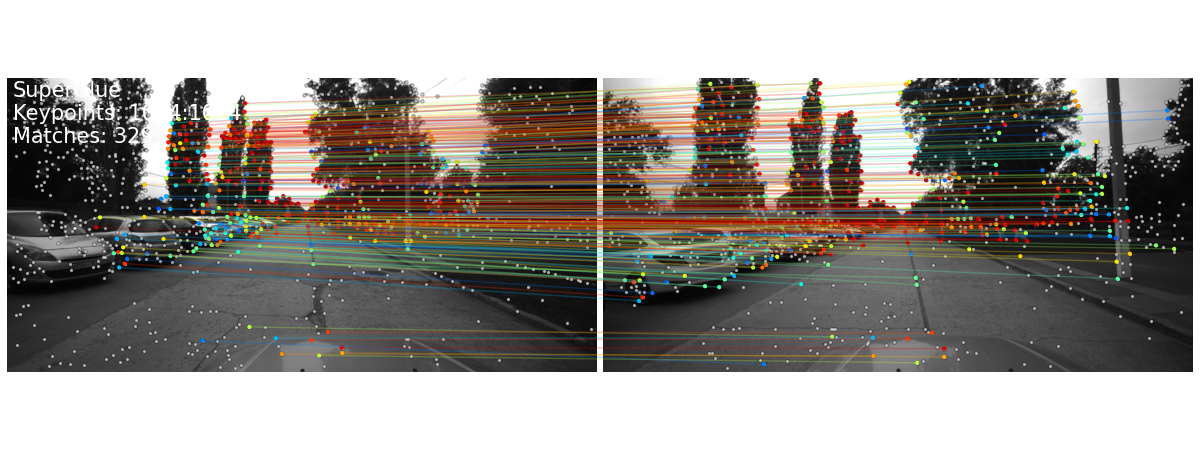

In [98]:
image = Image.open(join(RESULTS_DIR, 'keypoint_matches', keypoint_matches_img_filenames[IDX]))
image.show()

In [99]:
def visualize_relative_keypoint_poses(relative_query_points, relative_db_points,):
    q_x = np.squeeze(relative_query_points[0, :])
    q_y = np.squeeze(relative_query_points[1, :])
    q_z = np.squeeze(relative_query_points[2, :])

    db_x = np.squeeze(relative_db_points[0, :])
    db_y = np.squeeze(relative_db_points[1, :])
    db_z = np.squeeze(relative_db_points[2, :])
    
    fig = go.Figure(data=[go.Scatter3d(x=db_x, y=db_y, z=db_z,
                                       mode='markers', name = 'Mapping (Database)',
                                       marker=dict(size=4, color='blue',
                                                   colorscale='Viridis', opacity=0.5)),
                          go.Scatter3d(x=q_x, y=q_y, z=q_z,
                                       mode='markers', name = 'Query',
                                       marker=dict(size=4, color='red',
                                                   colorscale='Viridis', opacity=0.5))],)
    fig.update_layout(title="Plot 3D")
    fig.show()


visualize_relative_keypoint_poses(query_keypoints[IDX], db_keypoints[IDX])

In [100]:
def visualize_absolute_keypoint_poses(relative_query_points, relative_db_points, estimated_pose, gt_pose, db_pose):
    q_x = np.squeeze(relative_query_points[0, :])
    q_y = np.squeeze(relative_query_points[1, :])
    q_z = np.squeeze(relative_query_points[2, :])

    db_x = np.squeeze(relative_db_points[0, :])
    db_y = np.squeeze(relative_db_points[1, :])
    db_z = np.squeeze(relative_db_points[2, :])
    
    size = relative_query_points.shape[1]
    abs_points_q = np.append(relative_query_points, np.ones((1,size)), axis = 0)
    abs_points_q = np.matmul(estimated_pose, abs_points_q)
    abs_q_x, abs_q_y, abs_q_z = abs_points_q[:3,:]
    
    size = relative_db_points.shape[1]
    abs_points_db = np.append(relative_db_points, np.ones((1,size)), axis = 0)
    abs_points_db = np.matmul(db_pose, abs_points_db)
    abs_db_x, abs_db_y, abs_db_z = abs_points_db[:3,:]
    
    size = relative_query_points.shape[1]
    abs_points_gt = np.append(relative_query_points, np.ones((1,size)), axis = 0)
    abs_points_gt = np.matmul(gt_pose, abs_points_gt)
    abs_gt_x, abs_gt_y, abs_gt_z = abs_points_gt[:3,:]
    
    fig = go.Figure(data=[go.Scatter3d(x=abs_q_x, y=abs_q_y, z=abs_q_z,
                                       mode='markers', name = 'Query',
                                       marker=dict(size=4, color='red',
                                                   colorscale='Viridis', opacity=0.5)),
                          go.Scatter3d(x=abs_db_x, y=abs_db_y, z=abs_db_z,
                                       mode='markers', name = 'Mapping (Database)',
                                       marker=dict(size=4, color='blue',
                                                   colorscale='Viridis', opacity=0.5)),
                          go.Scatter3d(x=abs_gt_x, y=abs_gt_y, z=abs_gt_z,
                                       mode='markers', name = 'Ground truth',
                                       marker=dict(size=4, color='green',
                                                   colorscale='Viridis', opacity=0.5)),
                         ])
    fig.update_layout(title="Plot 3D")
    fig.show()


visualize_absolute_keypoint_poses(query_keypoints[IDX], db_keypoints[IDX],
                                  estimated_poses[IDX], gt_poses[IDX], db_poses[IDX])